### Data import

***
***
Code begins here 
***
***

In [340]:
!pip install mahotas

     |████████████████████████████████| 1.5 MB 6.3 MB/s eta 0:00:01
  Created wheel for mahotas: filename=mahotas-1.4.9-cp37-cp37m-macosx_10_9_x86_64.whl size=1780962 sha256=3e5c54b071d05d42d0b28c88acff462ea53752d47b821c2cc2b285f27d9a1127
  Stored in directory: /Users/fatmamoalla/Library/Caches/pip/wheels/76/80/37/e7d412704a39ced9120e3d9fa8cfb16f3e797844e5400d7246
Successfully built mahotas


# Import Data

In [5]:
cd fashion-product-images-small/

/Users/fatmamoalla/Desktop/OMA/S2/VIC/project/fashion-product-images-small


In [3]:
cd Desktop/OMA/S2/VIC/project/fashion-product-images-small/

[Errno 2] No such file or directory: 'Desktop/OMA/S2/VIC/project/fashion-product-images-small/'
/Users/fatmamoalla/Desktop/OMA/S2/VIC/project


In [6]:
import pandas as pd
styles = pd.read_csv('styles.csv',sep=',',error_bad_lines=False)
styles.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [7]:
dic_classes = list(set(styles['subCategory']))
dic_classes.sort()
dic ={ classe: idx for (idx, classe) in enumerate(dic_classes)}
print(dic)

{'Accessories': 0, 'Apparel Set': 1, 'Bags': 2, 'Bath and Body': 3, 'Beauty Accessories': 4, 'Belts': 5, 'Bottomwear': 6, 'Cufflinks': 7, 'Dress': 8, 'Eyes': 9, 'Eyewear': 10, 'Flip Flops': 11, 'Fragrance': 12, 'Free Gifts': 13, 'Gloves': 14, 'Hair': 15, 'Headwear': 16, 'Home Furnishing': 17, 'Innerwear': 18, 'Jewellery': 19, 'Lips': 20, 'Loungewear and Nightwear': 21, 'Makeup': 22, 'Mufflers': 23, 'Nails': 24, 'Perfumes': 25, 'Sandal': 26, 'Saree': 27, 'Scarves': 28, 'Shoe Accessories': 29, 'Shoes': 30, 'Skin': 31, 'Skin Care': 32, 'Socks': 33, 'Sports Accessories': 34, 'Sports Equipment': 35, 'Stoles': 36, 'Ties': 37, 'Topwear': 38, 'Umbrellas': 39, 'Vouchers': 40, 'Wallets': 41, 'Watches': 42, 'Water Bottle': 43, 'Wristbands': 44}


# Build helpers functions

In [20]:
cd ..

/Users/fatmamoalla/Desktop/OMA/S2/VIC/project/fashion-product-images-small


In [393]:

import cv2
import numpy as np
import scipy
#from scipy.misc import imread
import pickle
import random
import os
import matplotlib.pyplot as plt
import time

# Feature extractor
def extract_features(image_path, vector_size=90):
    image = cv2.imread(image_path)
    plt.imshow(image)
    sift = cv2.xfeatures2d.SIFT_create()
    # computing descriptors vector
    kps, dsc =sift.detectAndCompute(image,None)
    
    needed_size = (vector_size * 64)
    # Flatten all of them in one big vector - our feature vector
    if not(dsc is None):
        dsc = dsc.flatten()
    elif dsc is None:
        dsc = []
    if np.size(dsc) < needed_size:
    # if we have less the 32 descriptors then just adding zeros at the
    # end of our feature vector
        dsc = np.concatenate([dsc, np.zeros(needed_size - np.size(dsc))])
        print('des after', np.shape(dsc))
    return dsc

def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)


# important 
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [410]:

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path,'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        self.kmeans = None
        
    def update_matrix(self):
        max_features = 0
        self.names=[]
        self.matrix =[]
        for k, v in self.data.items():
            v0 = v.tolist()
            print('k',k)
            print('vector',np.shape(v0))
            self.names.append(k)
            self.matrix.append(np.array(v0).reshape(-1,1))
            if len(v0) > max_features :
                 max_features = len(v0)
        print('max_features',max_features)
        
        self.matrix = np.array(self.matrix)
        
        self.names = np.array(self.names)
        

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        #v = vector
        print('query vector =',np.shape(v))
        print('reference matrix = ',np.shape(self.matrix))
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)
    
    
    def cluster_vocab (self):
        descriptor_list = self.matrix
        kmeans = KMeans(n_clusters = 10)
        kmeans.fit(descriptor_list[:,:,0])
        self.kmeans = kmeans
        his_vocab =[]
        for i in range(len(descriptor_list)):
            his_vocab.append(build_histogram(descriptor_list[i].reshape(-1,1).T, kmeans))
        print(np.shape(his_vocab))
        return his_vocab
        
    def build_hist_one(self, image_path,kmeans):
        features = extract_features(image_path)
        print('image features',np.shape(features))
        histogram = build_histogram(features.reshape(-1,1).T, kmeans)
        return histogram
        
        
        
    def match(self, image_path, topn=5):
        self.update_matrix()
        hist_vocab = self.cluster_vocab()
        histogram = self.build_hist_one(image_path,self.kmeans)
        neighbor = NearestNeighbors(n_neighbors = topn)
        neighbor.fit(hist_vocab)
        dist, result = neighbor.kneighbors([histogram])
        return dist, result

In [411]:
def show_img(path):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = 'images_test'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 3 random images 
    sample = random.sample(files, 3)
    start = time.time()
    batch_extractor(images_path)
    end = time.time()
    ma = Matcher('features.pck')
    print('features constructed in',end-start)
    
    
    for s in sample:
        print ('Query image ==========================================')
        start = time.time()
        show_img(s)
        dist, nei = ma.match(s, topn=3)
        end = time.time()
        print('Matched sample in',end-start)
        
        print ('Result images ========================================')
        print(np.shape(nei),nei)
        fig=plt.figure(figsize=(8, 8))
        for i,idx in enumerate(nei[0]):
            print(i,idx)
            img = cv2.imread(files[idx])
            fig.add_subplot(1,3,i+1)
            plt.imshow(img)
            
        plt.show()

            

# Run the matcher on all the images

- It takes 6 min to build the matcher for the whole dataset

Extracting features from image images_test/1165.jpg
des after (5760,)
Extracting features from image images_test/1525.jpg
des after (5760,)
Extracting features from image images_test/1526.jpg
des after (5760,)
Extracting features from image images_test/1528.jpg
des after (5760,)
Extracting features from image images_test/1529.jpg
des after (5760,)
Extracting features from image images_test/1535.jpg
des after (5760,)
Extracting features from image images_test/1553.jpg
des after (5760,)
Extracting features from image images_test/1554.jpg
des after (5760,)
Extracting features from image images_test/1555.jpg
des after (5760,)
Extracting features from image images_test/1557.jpg
des after (5760,)
Extracting features from image images_test/1562.jpg
des after (5760,)
Extracting features from image images_test/1579.jpg
des after (5760,)
Extracting features from image images_test/1581.jpg
des after (5760,)
Extracting features from image images_test/1582.jpg
des after (5760,)
Extracting features 

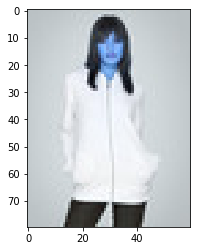

k 1165.jpg
vector (5760,)
k 1525.jpg
vector (5760,)
k 1526.jpg
vector (5760,)
k 1528.jpg
vector (5760,)
k 1529.jpg
vector (5760,)
k 1535.jpg
vector (5760,)
k 1553.jpg
vector (5760,)
k 1554.jpg
vector (5760,)
k 1555.jpg
vector (5760,)
k 1557.jpg
vector (5760,)
k 1562.jpg
vector (5760,)
k 1579.jpg
vector (5760,)
k 1581.jpg
vector (5760,)
k 1582.jpg
vector (5760,)
k 1583.jpg
vector (5760,)
k 1584.jpg
vector (5760,)
k 1591.jpg
vector (5760,)
max_features 5760
(17, 10)
des after (5760,)
image features (5760,)
Matched sample in 0.4282569885253906
Result images ========================================
(1, 3) [[15  0  1]]
0 15
1 0
2 1


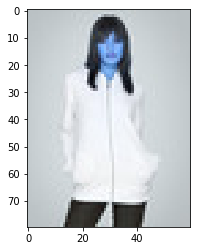

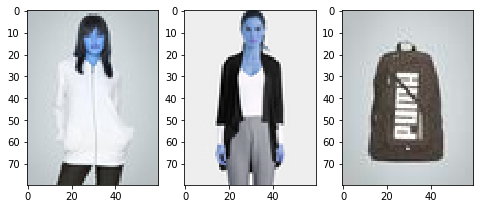

Query image ==========================================


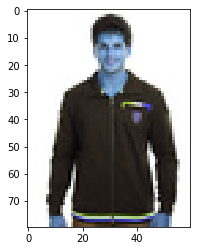

k 1165.jpg
vector (5760,)
k 1525.jpg
vector (5760,)
k 1526.jpg
vector (5760,)
k 1528.jpg
vector (5760,)
k 1529.jpg
vector (5760,)
k 1535.jpg
vector (5760,)
k 1553.jpg
vector (5760,)
k 1554.jpg
vector (5760,)
k 1555.jpg
vector (5760,)
k 1557.jpg
vector (5760,)
k 1562.jpg
vector (5760,)
k 1579.jpg
vector (5760,)
k 1581.jpg
vector (5760,)
k 1582.jpg
vector (5760,)
k 1583.jpg
vector (5760,)
k 1584.jpg
vector (5760,)
k 1591.jpg
vector (5760,)
max_features 5760
(17, 10)
des after (5760,)
image features (5760,)
Matched sample in 0.7961289882659912
Result images ========================================
(1, 3) [[3 0 1]]
0 3
1 0
2 1


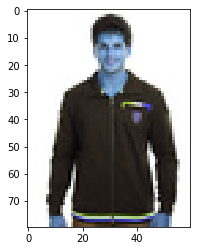

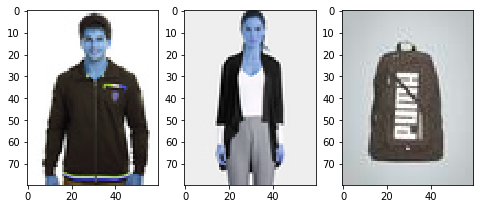

Query image ==========================================


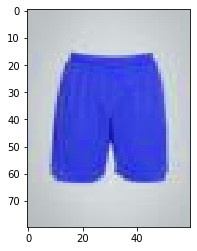

k 1165.jpg
vector (5760,)
k 1525.jpg
vector (5760,)
k 1526.jpg
vector (5760,)
k 1528.jpg
vector (5760,)
k 1529.jpg
vector (5760,)
k 1535.jpg
vector (5760,)
k 1553.jpg
vector (5760,)
k 1554.jpg
vector (5760,)
k 1555.jpg
vector (5760,)
k 1557.jpg
vector (5760,)
k 1562.jpg
vector (5760,)
k 1579.jpg
vector (5760,)
k 1581.jpg
vector (5760,)
k 1582.jpg
vector (5760,)
k 1583.jpg
vector (5760,)
k 1584.jpg
vector (5760,)
k 1591.jpg
vector (5760,)
max_features 5760
(17, 10)
des after (5760,)
image features (5760,)
Matched sample in 0.6919851303100586
Result images ========================================
(1, 3) [[8 2 7]]
0 8
1 2
2 7


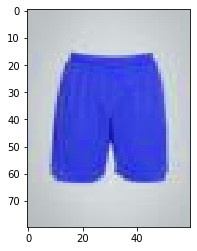

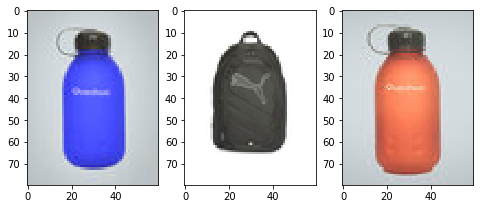

In [412]:
nei = run()

In [ ]:
nei


In [ ]:
l

In [ ]:
np.shape(l)

[array([0., 1., 0.], dtype=float32),
 array([10.,  1.,  5.], dtype=float32),
 array([11.,  1.,  7.], dtype=float32)]

In [242]:
import cv2

# defining feature extractor that we want to use
extractor = cv2.xfeatures2d.SIFT_create()

def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

In [277]:
def flatten_array(arr):
    x =[]
    for i,l in enumerate(arr):
        print(i,np.shape(l),type(l))
        x.append(l.tolist())
    print(np.shape(x))
    return x


        

Extracting features from image images_test/1165.jpg
des after (5760,)
[45. 11.  0. ...  0.  0.  0.]
Extracting features from image images_test/1525.jpg
des after (5760,)
[1. 0. 0. ... 0. 0. 0.]
Extracting features from image images_test/1526.jpg
des after (5760,)
[31.  3.  1. ...  0.  0.  0.]
Extracting features from image images_test/1528.jpg
des after (5760,)
[7. 1. 5. ... 0. 0. 0.]
Extracting features from image images_test/1529.jpg
des after (5760,)
[26. 47. 64. ...  0.  0.  0.]
Extracting features from image images_test/1535.jpg
des after (5760,)
[ 7. 33. 60. ...  0.  0.  0.]
Extracting features from image images_test/1553.jpg
des after (5760,)
[0. 0. 0. ... 0. 0. 0.]
Extracting features from image images_test/1554.jpg
des after (5760,)
[ 4.  3. 64. ...  0.  0.  0.]
Extracting features from image images_test/1555.jpg
des after (5760,)
[ 3.  4. 79. ...  0.  0.  0.]
Extracting features from image images_test/1557.jpg
des after (5760,)
[28. 19.  0. ...  0.  0.  0.]
Extracting feature

ValueError: setting an array element with a sequence.

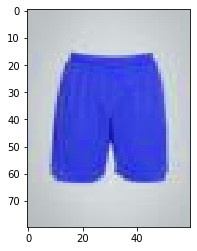

In [305]:
# construct sift vocabulary:
from sklearn.cluster import KMeans
images_path = 'images_test'
files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
features_list = []
result = dict()
for f in files:
    print ('Extracting features from image %s' % f)
    name = f.split('/')[-1].lower()
    dsc = extract_features(f)
    print(dsc)
    result[name] = dsc
    if len(result[name])>0 :
        features_list.append(vector)

#features_list = np.array(features_list)

start = time.time()    
kmeans = KMeans(n_clusters = 10)
kmeans.fit(descriptor_list)
end= time.time()

print('clustering ended in ',end-start)







In [ ]:


    # getting 3 random images 
    sample = random.sample(files, 3)
    start = time.time()
    batch_extractor(images_path)
    end = time.time()
    ma = Matcher('features.pck')
    print('features constructed in',end-start)
    for s in sample: